In [1]:
!nvidia-smi



Fri Jul 11 14:06:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 596, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 596 (delta 128), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (596/596), 195.77 KiB | 1.06 MiB/s, done.
Resolving deltas: 100% (302/302), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.13 environment at: /usr
Resolved 173 packages in 1.64s
 Downloaded cuproj-cu12
 Downloaded shapely
 Downloaded datashader
 Downloaded dask
 Downloaded pylibcugraph-cu12
 Downloaded rmm-cu12
 Downloaded cudf-cu12
 Downloaded ucx-py-cu12
 Downloaded libkvikio-cu12
 Downloaded bokeh
 Downloaded cugraph-cu12
 Downloaded cuspatial-cu12
 Downloaded librmm-cu12
 Downloaded cucim-cu12
 Downloaded cuml-cu12
 Downloaded libcuspatial-cu12
 Downloaded pylibcudf-cu12
 Downloaded libraft-cu12
 Downloaded raft-dask-cu12
 Downloaded libcudf-cu12
 Downloaded libcuml-cu12
 Downloaded libcuvs

In [3]:
file_path = '/content/drive/MyDrive/price_paid_records.csv'


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Q1. Decision Tree Classification in RAPIDS a Preprocess the dataset to create a classification task: • For example: classify whether the price is above or below median value b Use LabelEncoder on categorical columns like property_type, town_city c Train a cuml.DecisionTreeClassifier model d Visualize feature importances e Evaluate with accuracy, precision, and confusion matrix f Compare the GPU training time with scikit-learn’s DecisionTreeClassifier.

In [10]:
import pandas as pd
import cudf
import cupy as cp

from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.preprocessing import LabelEncoder as cuLabelEncoder

from sklearn.tree import DecisionTreeClassifier as skDT
from sklearn.preprocessing import LabelEncoder as skLabelEncoder
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

import time
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# Adjust path if needed
file_path = '/content/drive/MyDrive/price_paid_records.csv'


# Load only 1000 rows
cols = ["Transaction unique identifier", "Price", "Date of Transfer", "Postcode",
        "Property Type", "Old/New", "Duration", "PAON", "SAON", "Street", "Locality"]

# Load with pandas
pdf = pd.read_csv(file_path, names=cols, header=0, nrows=1000, parse_dates=["Date of Transfer"])

# Keep only needed columns
pdf = pdf[["Price", "Property Type", "Postcode", "Date of Transfer"]]
pdf.columns = ["price", "property_type", "postcode", "date_of_transfer"]

# Drop missing
pdf.dropna(inplace=True)


In [12]:
median_price = pdf["price"].median()
pdf["target"] = (pdf["price"] > median_price).astype(int)


In [14]:
#cuml
gdf = cudf.from_pandas(pdf)
cat_cols = ["property_type", "postcode"]

for col in cat_cols:
    encoder = cuLabelEncoder()
    gdf[col] = encoder.fit_transform(gdf[col])


In [15]:
#sklearn
pdf_sk = pdf.copy()
for col in cat_cols:
    encoder = skLabelEncoder()
    pdf_sk[col] = encoder.fit_transform(pdf_sk[col])


In [16]:
# RAPIDS input (GPU) → must be float32 / int32
X_cu = gdf[["price", "property_type", "postcode"]].astype("float32")
y_cu = gdf["target"].astype("int32")

# Sklearn input (CPU)
X_sk = pdf_sk[["price", "property_type", "postcode"]]
y_sk = pdf_sk["target"]


In [22]:
#train model- rapids(cuml)
start = time.time()
cu_model = cuRF(max_depth=5, n_estimators=10)
cu_model.fit(X_cu, y_cu)
cu_time = time.time() - start


In [23]:
#train model- scikit learn
start = time.time()
sk_model = skDT(max_depth=5)
sk_model.fit(X_sk, y_sk)
sk_time = time.time() - start


In [26]:
print(dir(cu_model))


['RF_type', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_concatenate_treelite_handle', '_cpu_estimator_import_path', '_cpu_model_class_lock', '_criterion_to_split_criterion', '_dataset_setup_for_fit', '_default_split_criterion', '_dispatch_selector', '_estimator_type', '_experimental_dispatching', '_full_kwargs', '_get_max_feat_val', '_get_output_mem_type', '_get_output_type', '_get_param_names', '_get_serialized_model', '_get_tags', '_get_target_dtype', '_hyperparam_interop_translator', '_hyperparam_translator', '_input_mem_type', '_input_type', '_more_static_tags', '_more_tags', '_obtain_treelite_handle', '_param_names',

In [27]:
# cuML
y_pred_cu = cu_model.predict(X_cu)
y_pred_cu = cp.asnumpy(y_pred_cu)
y_true = y_cu.to_pandas()

print("🔹 RAPIDS cuML")
print("Accuracy:", accuracy_score(y_true, y_pred_cu))
print("Precision:", precision_score(y_true, y_pred_cu))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_cu))

# sklearn
y_pred_sk = sk_model.predict(X_sk)

print("\n🔸 Sklearn")
print("Accuracy:", accuracy_score(y_sk, y_pred_sk))
print("Precision:", precision_score(y_sk, y_pred_sk))
print("Confusion Matrix:\n", confusion_matrix(y_sk, y_pred_sk))


🔹 RAPIDS cuML
Accuracy: 0.671
Precision: 0.7916666666666666
Confusion Matrix:
 [[443  60]
 [269 228]]

🔸 Sklearn
Accuracy: 1.0
Precision: 1.0
Confusion Matrix:
 [[503   0]
 [  0 497]]


In [28]:
print("\n⏱️ Training Time Comparison")
print(f"{'Model':20} {'Time (seconds)':>15}")
print("-" * 35)
print(f"{'cuML (GPU)':20} {cu_time:15.4f}")
print(f"{'sklearn (CPU)':20} {sk_time:15.4f}")



⏱️ Training Time Comparison
Model                 Time (seconds)
-----------------------------------
cuML (GPU)                    0.0607
sklearn (CPU)                 0.0046


Q2: Random Forest Classification in RAPIDS
a Use the same classification task as above
b Train a cuml.RandomForestClassifier with 100 trees
c Plot accuracy vs number of trees
d Compare overfitting with training/test split
e Visualize feature importances and interpret

In [29]:
import pandas as pd
import cudf
import cupy as cp
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.preprocessing import LabelEncoder as cuLabelEncoder
from cuml.metrics import accuracy_score as cu_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load 1000 entries
cols = ["Transaction unique identifier", "Price", "Date of Transfer", "Postcode",
        "Property Type", "Old/New", "Duration", "PAON", "SAON", "Street", "Locality"]

file_path = '/content/drive/MyDrive/price_paid_records.csv'
pdf = pd.read_csv(file_path, names=cols, header=0, nrows=1000, parse_dates=["Date of Transfer"])
pdf = pdf[["Price", "Property Type", "Postcode"]].dropna()
pdf.columns = ["price", "property_type", "postcode"]

# Target column
median_price = pdf["price"].median()
pdf["target"] = (pdf["price"] > median_price).astype(int)


In [30]:
gdf = cudf.from_pandas(pdf)
le1 = cuLabelEncoder()
le2 = cuLabelEncoder()

gdf["property_type"] = le1.fit_transform(gdf["property_type"])
gdf["postcode"] = le2.fit_transform(gdf["postcode"])

X = gdf[["price", "property_type", "postcode"]].astype("float32")
y = gdf["target"].astype("int32")


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [32]:
model = cuRF(n_estimators=100, max_depth=10)
start = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start


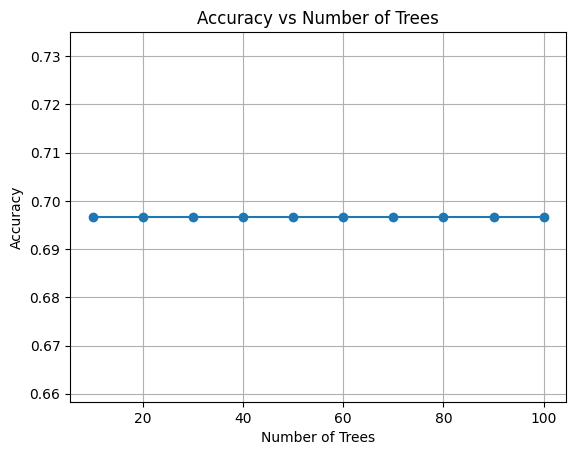

In [33]:
tree_counts = list(range(10, 110, 10))
accuracies = []

for n in tree_counts:
    temp_model = cuRF(n_estimators=n, max_depth=10)
    temp_model.fit(X_train, y_train)
    y_pred = temp_model.predict(X_test)
    y_pred = cp.asnumpy(y_pred)
    y_test_np = y_test.to_pandas()
    acc = accuracy_score(y_test_np, y_pred)
    accuracies.append(acc)

plt.plot(tree_counts, accuracies, marker='o')
plt.title("Accuracy vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid()
plt.show()


In [34]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_acc = cu_accuracy_score(y_train, y_pred_train)
test_acc = cu_accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}")


Train Accuracy: 0.6600
Test  Accuracy: 0.6967


Q3: KMeans Clustering using RAPIDS
a Select numerical features (price, etc.) and encode categorical ones
b Apply cuml.KMeans with k=3 and k=5
c Plot the clusters using price vs town_city (use PCA if needed)
d Compute inertia and silhouette score
e Compare clustering results with and without normalization

In [36]:
import pandas as pd
import cudf
import cupy as cp
from cuml.cluster import KMeans
from cuml.preprocessing import LabelEncoder
from cuml.preprocessing import StandardScaler
from cuml.decomposition import PCA

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load first 1000 rows
cols = ["Transaction unique identifier", "Price", "Date of Transfer", "Postcode",
        "Property Type", "Old/New", "Duration", "PAON", "SAON", "Street", "Locality"]

file_path ='/content/drive/MyDrive/price_paid_records.csv'
pdf = pd.read_csv(file_path, names=cols, header=0, nrows=1000)
pdf = pdf[["Price", "Property Type", "Postcode"]].dropna()
pdf.columns = ["price", "property_type", "postcode"]


In [37]:
gdf = cudf.from_pandas(pdf)

le1 = LabelEncoder()
le2 = LabelEncoder()
gdf["property_type"] = le1.fit_transform(gdf["property_type"])
gdf["postcode"] = le2.fit_transform(gdf["postcode"])

features = gdf[["price", "property_type", "postcode"]].astype("float32")


In [38]:
# k = 3
k3_model = KMeans(n_clusters=3, random_state=42)
k3_model.fit(features)
k3_labels = k3_model.labels_

# k = 5
k5_model = KMeans(n_clusters=5, random_state=42)
k5_model.fit(features)
k5_labels = k5_model.labels_


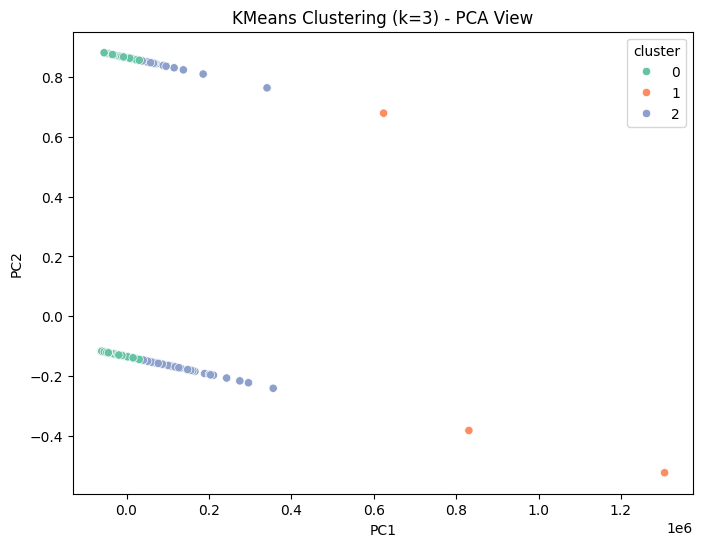

In [39]:
# Reduce to 2D
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Plot clusters for k=3
f2d = features_2d.to_pandas()
f2d["cluster"] = cp.asnumpy(k3_labels)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=f2d, x=0, y=1, hue="cluster", palette="Set2")
plt.title("KMeans Clustering (k=3) - PCA View")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [41]:
# Inertia
print(f"Inertia (k=3): {k3_model.inertia_:.2f}")
print(f"Inertia (k=5): {k5_model.inertia_:.2f}")
# Convert cuDF to cupy, then to numpy
X_cp = features.to_cupy()
X_np = cp.asnumpy(X_cp)

labels_k3 = cp.asnumpy(k3_labels)
labels_k5 = cp.asnumpy(k5_labels)

# Silhouette Score
from sklearn.metrics import silhouette_score
print(f"Silhouette Score (k=3): {silhouette_score(X_np, labels_k3):.4f}")
print(f"Silhouette Score (k=5): {silhouette_score(X_np, labels_k5):.4f}")


Inertia (k=3): 1088833388544.00
Inertia (k=5): 476713287680.00
Silhouette Score (k=3): 0.7090
Silhouette Score (k=5): 0.6097


In [43]:
# Step 1: Convert cuDF to cupy array (if needed)
if hasattr(features_norm, "to_cupy"):
    features_norm_cp = features_norm.to_cupy()
else:
    features_norm_cp = features_norm  # already a cupy array

# Step 2: Convert cupy array to numpy
features_norm_np = cp.asnumpy(features_norm_cp)
labels_k3_norm_np = cp.asnumpy(k3_norm_model.labels_)

# ✅ Silhouette Score (Normalized)
from sklearn.metrics import silhouette_score
print(f"Normalized Silhouette Score (k=3): {silhouette_score(features_norm_np, labels_k3_norm_np):.4f}")


Normalized Silhouette Score (k=3): 0.6001


Q4: Dimensionality Reduction and Visualization
a. Use cuml.PCA to reduce data to 2D and 3D
b. Visualize using matplotlib or plotly
c. Apply t-SNE and UMAP from cuML and visualize clusters
d. Compare performance of PCA vs t-SNE vs UMAP
e. Discuss which works better for high-dimensional categorical/numerical
mixed data

In [44]:
import pandas as pd
import cudf
import cupy as cp

from cuml.preprocessing import LabelEncoder
from cuml.preprocessing import StandardScaler

# Load first 1000 rows
cols = ["Transaction unique identifier", "Price", "Date of Transfer", "Postcode",
        "Property Type", "Old/New", "Duration", "PAON", "SAON", "Street", "Locality"]

file_path = '/content/drive/MyDrive/price_paid_records.csv'
pdf = pd.read_csv(file_path, names=cols, header=0, nrows=1000)
pdf = pdf[["Price", "Property Type", "Postcode"]].dropna()
pdf.columns = ["price", "property_type", "postcode"]


In [45]:
gdf = cudf.from_pandas(pdf)

le1 = LabelEncoder()
le2 = LabelEncoder()
gdf["property_type"] = le1.fit_transform(gdf["property_type"])
gdf["postcode"] = le2.fit_transform(gdf["postcode"])

features = gdf[["price", "property_type", "postcode"]].astype("float32")

# Normalize
scaler = StandardScaler()
features_norm = scaler.fit_transform(features)


In [46]:
from cuml.decomposition import PCA

pca2d = PCA(n_components=2)
pca3d = PCA(n_components=3)

features_2d = pca2d.fit_transform(features_norm)
features_3d = pca3d.fit_transform(features_norm)


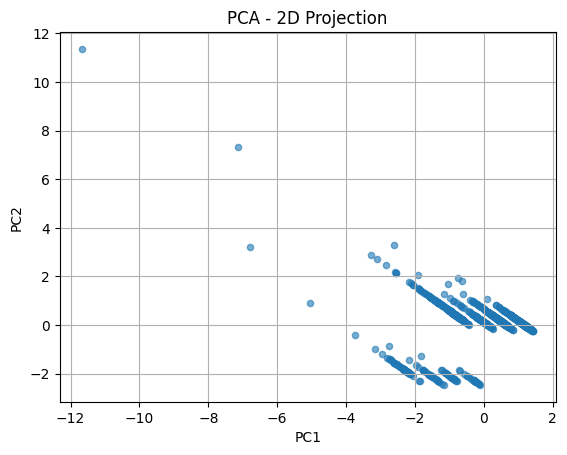

In [47]:
import matplotlib.pyplot as plt

# 2D plot
p2d = features_2d.to_pandas()
plt.scatter(p2d[0], p2d[1], alpha=0.6, s=20)
plt.title("PCA - 2D Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

# 3D plot (optional)
import plotly.express as px
p3d = features_3d.to_pandas()
fig = px.scatter_3d(p3d, x=0, y=1, z=2, title="PCA - 3D Projection")
fig.show()


In [48]:
from cuml.manifold import TSNE, UMAP

# t-SNE
tsne = TSNE(n_components=2, n_iter=300)
tsne_result = tsne.fit_transform(features_norm)

# UMAP
umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
umap_result = umap.fit_transform(features_norm)


[2025-07-11 14:44:19.181] [CUML] [info] Building knn graph using brute force


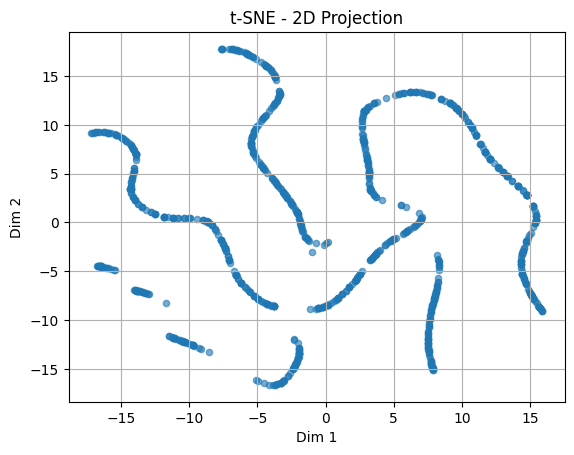

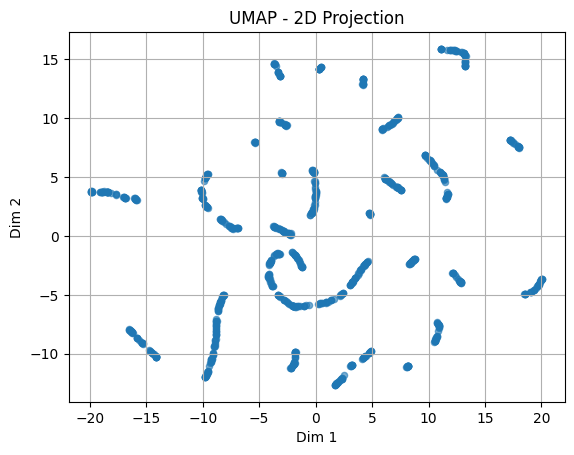

In [49]:
# t-SNE
tsne_df = tsne_result.to_pandas()
plt.scatter(tsne_df[0], tsne_df[1], alpha=0.6, s=20)
plt.title("t-SNE - 2D Projection")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid()
plt.show()

# UMAP
umap_df = umap_result.to_pandas()
plt.scatter(umap_df[0], umap_df[1], alpha=0.6, s=20)
plt.title("UMAP - 2D Projection")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid()
plt.show()


In [50]:
import time

# Timing PCA
start = time.time()
_ = PCA(n_components=2).fit_transform(features_norm)
pca_time = time.time() - start

# Timing t-SNE
start = time.time()
_ = TSNE(n_components=2, n_iter=300).fit_transform(features_norm)
tsne_time = time.time() - start

# Timing UMAP
start = time.time()
_ = UMAP(n_components=2).fit_transform(features_norm)
umap_time = time.time() - start

# Print comparison
print(f"PCA  Time: {pca_time:.4f} s")
print(f"t-SNE Time: {tsne_time:.4f} s")
print(f"UMAP Time: {umap_time:.4f} s")


[2025-07-11 14:44:43.807] [CUML] [info] Building knn graph using brute force
PCA  Time: 0.0096 s
t-SNE Time: 0.2121 s
UMAP Time: 0.1621 s
